In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
if torch.cuda.is_available():
    print("CUDA is available. GPU is enabled!")
else:
    print("CUDA is not available. GPU is not enabled.")


CUDA is available. GPU is enabled!


In [ ]:
# @title Importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import root_mean_squared_error

In [ ]:
# @title Reading source data
pd.set_option('display.max_columns', 12)
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/simulated_weekly.xlsx")
print('Shape of datafreame:', df.shape, "\n-----------------")
pd.set_option('display.max_columns', None)
df

Shape of datafreame: (208, 13) 
-----------------


,Unnamed: 0,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,events,newsletter
0,1,2015-11-23,2.754372e+06,22358.346667,0.000000,12728.488889,2.430128e+07,0.000000,0.000000,8125009,7607.132915,na,19401.653846
1,2,2015-11-30,2.584277e+06,28613.453333,0.000000,0.000000,5.527033e+06,9837.238486,4133.333333,7901549,1141.952450,na,14791.000000
2,3,2015-12-07,2.547387e+06,0.000000,132278.400000,453.866667,1.665159e+07,12044.119653,3786.666667,8300197,4256.375378,na,14544.000000
3,4,2015-12-14,2.875220e+06,83450.306667,0.000000,17680.000000,1.054977e+07,12268.070319,4253.333333,8122883,2800.490677,na,2800.000000
4,5,2015-12-21,2.215953e+06,0.000000,277336.000000,0.000000,2.934090e+06,9467.248023,3613.333333,7105985,689.582605,na,15478.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,204,2019-10-14,2.456240e+06,0.000000,32230.933333,20496.488889,0.000000e+00,50946.774471,14946.666667,7612762,0.000000,na,28157.000000
204,205,2019-10-21,2.182825e+06,20655.680000,0.000000,0.000000,1.896065e+07,34560.015940,13826.666667,6701667,4454.152517,na,10644.000000
205,206,2019-10-28,2.377707e+06,2931.000000,7516.800000,2330.133333,0.000000e+00,46129.234713,15293.333333,7688920,0.000000,na,9597.000000
206,207,2019-11-04,2.732825e+06,2993.733333,0.000000,3206.844444,0.000000e+00,50569.330154,17880.000000,8815710,0.000000,na,90189.000000


In [ ]:
# @title Checking data types of each columns
print(df.dtypes)

DATE          datetime64[ns]
revenue              float64
tv_S                 float64
ooh_S                float64
print_S              float64
search_S             float64
facebook_S           float64
dtype: object


In [ ]:
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.describe()

,DATE,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,newsletter
count,208,2.080000e+02,208.000000,208.000000,208.000000,2.080000e+02,208.000000,208.000000,2.080000e+02,208.000000,208.000000
mean,2017-11-16 12:00:00,1.822143e+06,14843.691218,43217.941026,3728.632265,8.153415e+06,16945.206847,5915.512821,5.538025e+06,2145.657826,22386.523669
min,2015-11-23 00:00:00,6.722500e+05,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2.240235e+06,0.000000,301.000000
25%,2016-11-19 06:00:00,1.165211e+06,0.000000,0.000000,0.000000,0.000000e+00,6280.684504,2353.333333,3.589581e+06,0.000000,9010.500000
50%,2017-11-16 12:00:00,1.874514e+06,0.000000,0.000000,0.000000,0.000000e+00,14265.252495,4806.666667,5.538524e+06,0.000000,19401.653846
75%,2018-11-13 18:00:00,2.378407e+06,18406.706667,50858.133333,4767.833333,1.373742e+07,25236.843560,8536.666667,7.311814e+06,3623.012233,27546.500000
max,2019-11-11 00:00:00,3.827520e+06,158046.573333,500361.600000,31922.311111,5.943276e+07,52188.128214,17880.000000,9.984742e+06,15400.391408,96236.000000
std,NaN,7.162286e+05,28558.366546,83991.426655,6483.070232,1.169913e+07,13614.093674,4702.502612,2.077192e+06,3160.363803,19104.164424


In [ ]:
# @title Checking null values
df.isnull().mean().sort_values(ascending=True)

,0
DATE,0.0
revenue,0.0
tv_S,0.0
ooh_S,0.0
print_S,0.0
facebook_I,0.0
search_clicks_P,0.0
search_S,0.0
competitor_sales_B,0.0
facebook_S,0.0


In [ ]:
# @title limiting required data
df = df[['DATE', 'revenue', 'tv_S',	'ooh_S',	'print_S', 'search_S',	'facebook_S']]
df

,DATE,revenue,tv_S,ooh_S,print_S,search_S,facebook_S
0,2015-11-23,2.754372e+06,22358.346667,0.000000,12728.488889,0.000000,7607.132915
1,2015-11-30,2.584277e+06,28613.453333,0.000000,0.000000,4133.333333,1141.952450
2,2015-12-07,2.547387e+06,0.000000,132278.400000,453.866667,3786.666667,4256.375378
3,2015-12-14,2.875220e+06,83450.306667,0.000000,17680.000000,4253.333333,2800.490677
4,2015-12-21,2.215953e+06,0.000000,277336.000000,0.000000,3613.333333,689.582605
...,...,...,...,...,...,...,...
203,2019-10-14,2.456240e+06,0.000000,32230.933333,20496.488889,14946.666667,0.000000
204,2019-10-21,2.182825e+06,20655.680000,0.000000,0.000000,13826.666667,4454.152517
205,2019-10-28,2.377707e+06,2931.000000,7516.800000,2330.133333,15293.333333,0.000000
206,2019-11-04,2.732825e+06,2993.733333,0.000000,3206.844444,17880.000000,0.000000


In [ ]:
dir(plt)

['AbstractContextManager',
 'Annotation',
 'Arrow',
 'Artist',
 'AutoLocator',
 'Axes',
 'Button',
 'Circle',
 'Enum',
 'ExitStack',
 'Figure',
 'FigureBase',
 'FigureCanvasBase',
 'FigureManagerBase',
 'FixedFormatter',
 'FixedLocator',
 'FormatStrFormatter',
 'Formatter',
 'FuncFormatter',
 'GridSpec',
 'IndexLocator',
 'Line2D',
 'LinearLocator',
 'Locator',
 'LogFormatter',
 'LogFormatterExponent',
 'LogFormatterMathtext',
 'LogLocator',
 'MaxNLocator',
 'MouseButton',
 'MultipleLocator',
 'Normalize',
 'NullFormatter',
 'NullLocator',
 'PolarAxes',
 'Polygon',
 'Rectangle',
 'ScalarFormatter',
 'Slider',
 'Subplot',
 'SubplotSpec',
 'TYPE_CHECKING',
 'Text',
 'TickHelper',
 'Widget',
 '_REPL_DISPLAYHOOK',
 '_ReplDisplayHook',
 '__annotations__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_api',
 '_auto_draw_if_interactive',
 '_backend_mod',
 '_color_sequences',
 '_colormaps',
 '_copy_docstring_and_deprecators

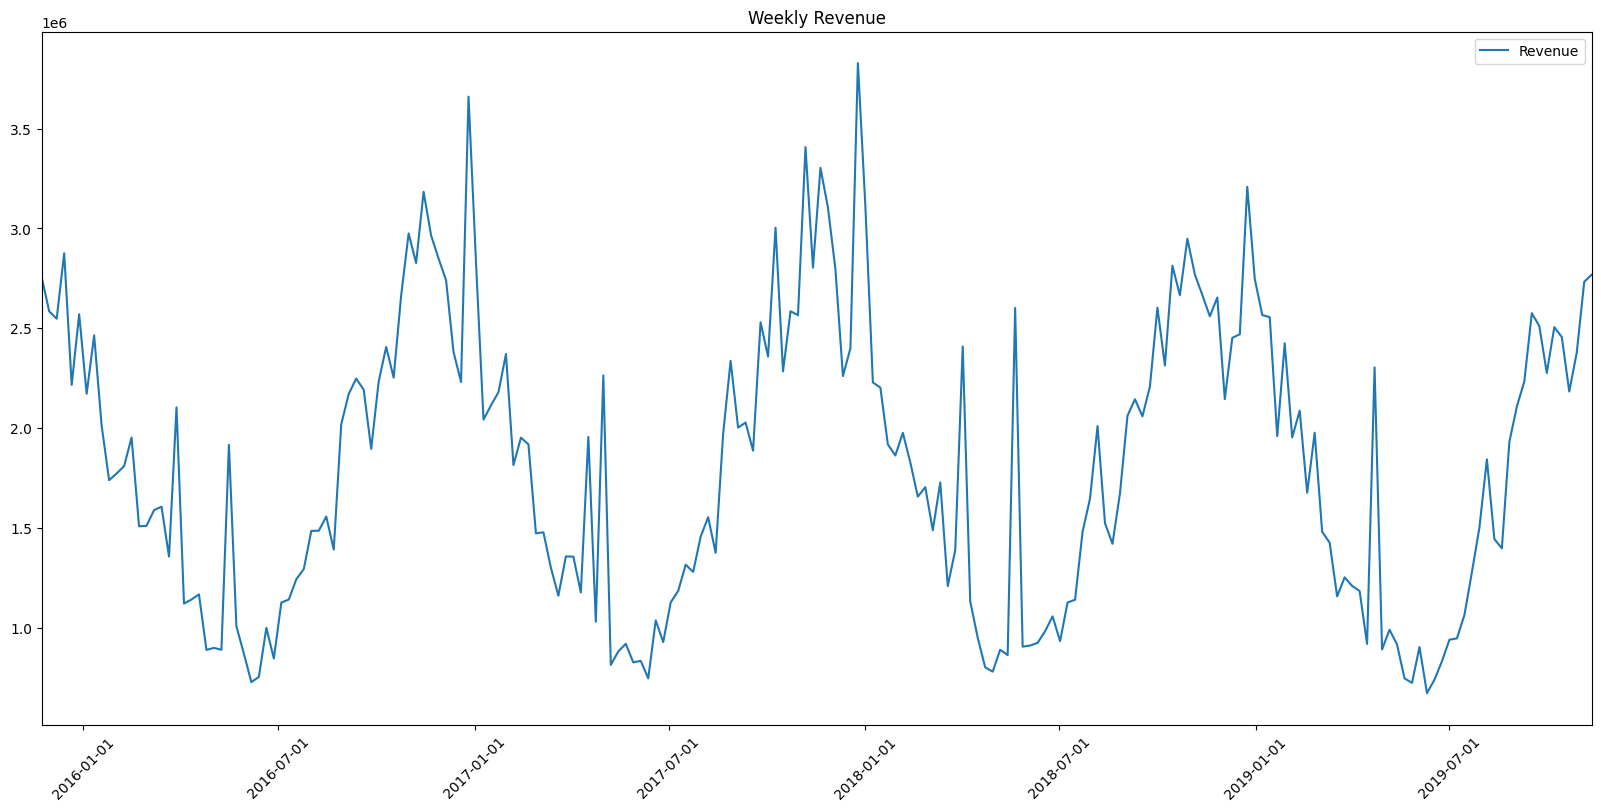

In [ ]:
# @title Data plots
plt.rcParams["figure.figsize"] = (20,9)
plt.margins(x=0)
plt.plot(df['DATE'], df['revenue'])
plt.legend(['Revenue'])
plt.xticks(rotation=45)
plt.title('Weekly Revenue')
dtFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.show()

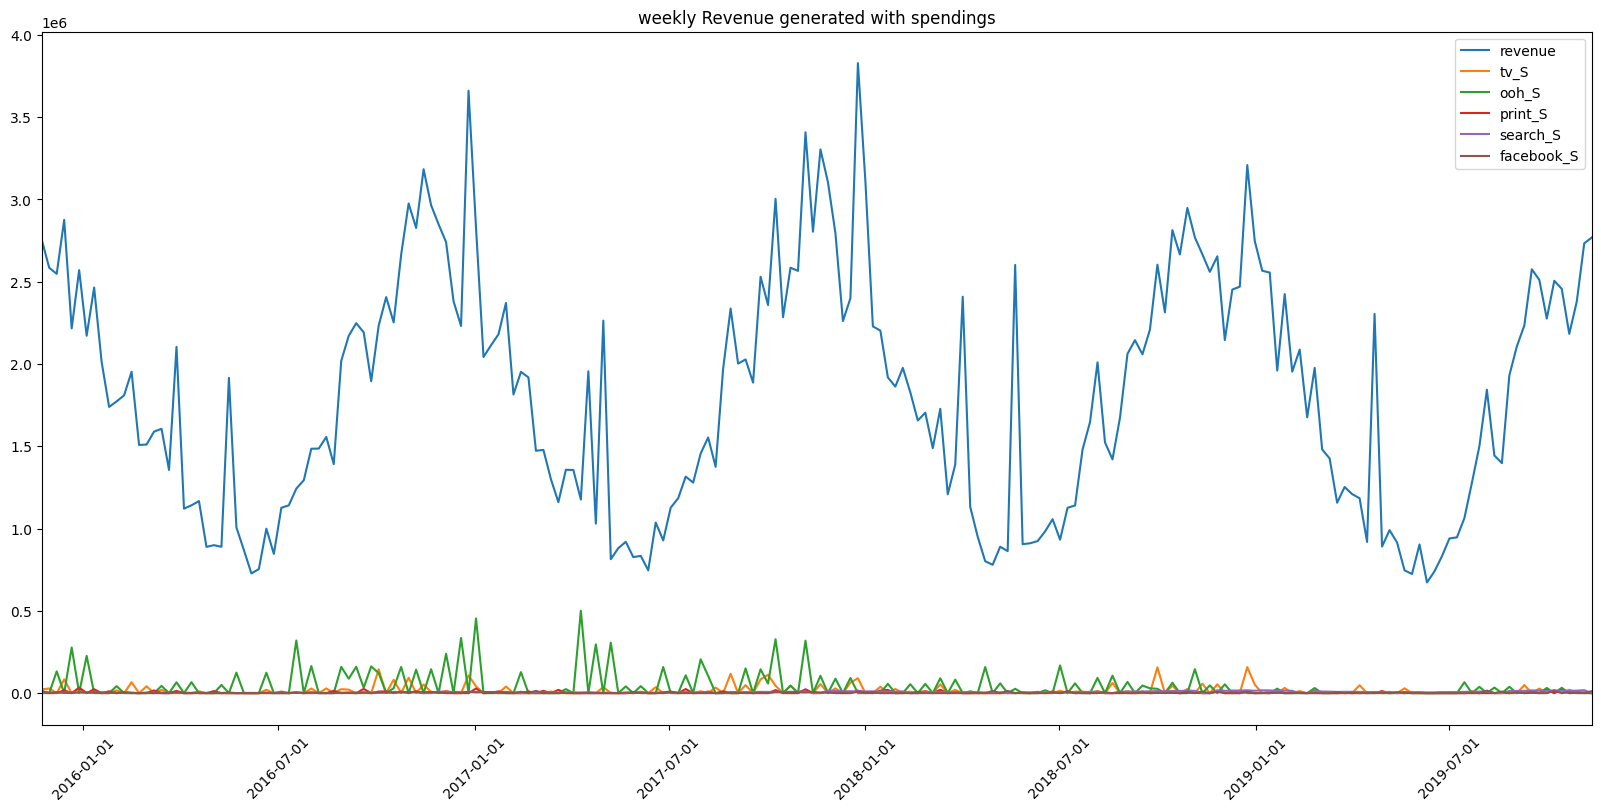

In [ ]:
plt.rcParams["figure.figsize"] = (20,9)
plt.margins(x=0)
plt.plot(df['DATE'], df['revenue'])
plt.plot(df['DATE'], df['tv_S'])
plt.plot(df['DATE'], df['ooh_S'])
plt.plot(df['DATE'], df['print_S'])
plt.plot(df['DATE'], df['search_S'])
plt.plot(df['DATE'], df['facebook_S'])
plt.legend(df.columns[1:])
plt.xticks(rotation=45)
plt.title('weekly Revenue generated with spendings')
dtFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.show()

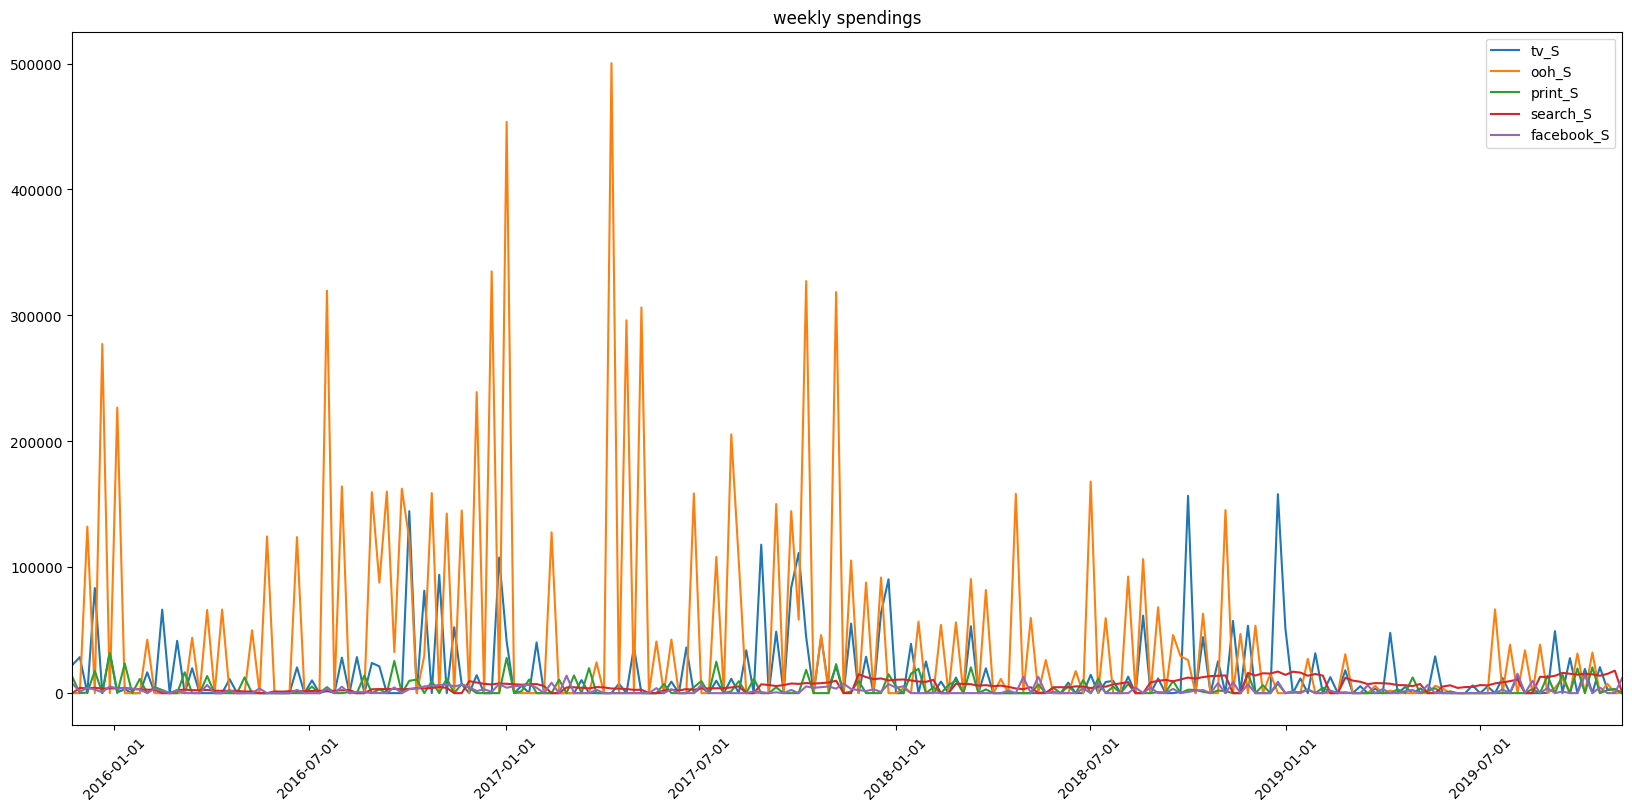

In [ ]:
plt.rcParams["figure.figsize"] = (20,9)
plt.margins(x=0)
# plt.plot(df['DATE'], df['revenue'])
plt.plot(df['DATE'], df['tv_S'])
plt.plot(df['DATE'], df['ooh_S'])
plt.plot(df['DATE'], df['print_S'])
plt.plot(df['DATE'], df['search_S'])
plt.plot(df['DATE'], df['facebook_S'])
plt.legend(df.columns[2:])
plt.xticks(rotation=45)
plt.title('weekly spendings')
dtFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.show()

<Axes: >

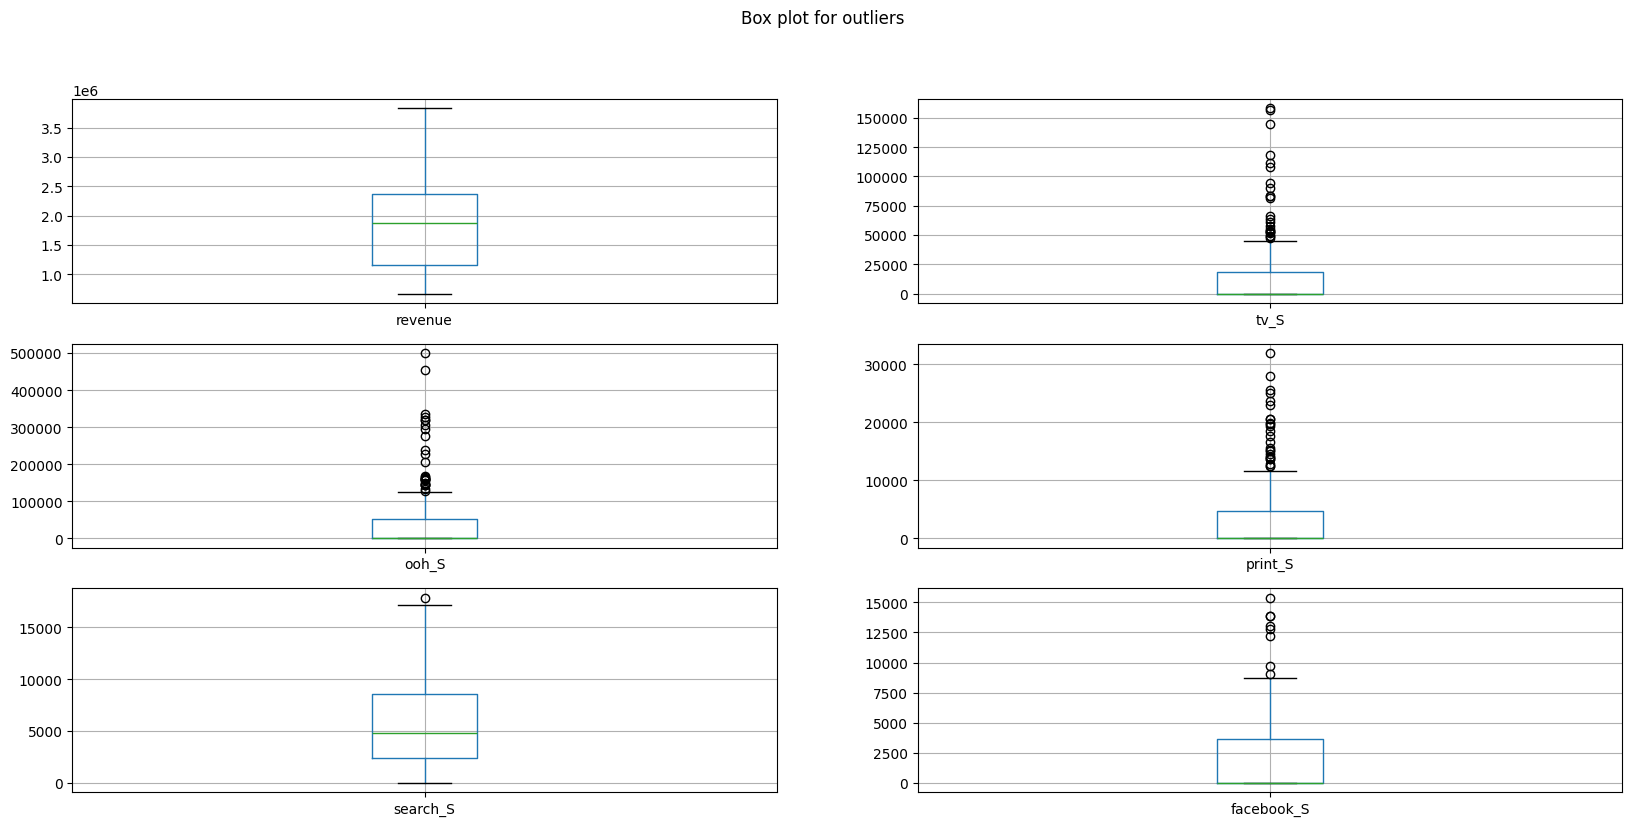

In [ ]:
# @title Outlier detection
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.suptitle('Box plot for outliers')
df.boxplot(column='revenue', ax=ax1)
df.boxplot(column='tv_S', ax=ax2)
df.boxplot(column='ooh_S', ax=ax3)
df.boxplot(column='print_S', ax=ax4)
df.boxplot(column='search_S', ax=ax5)
df.boxplot(column='facebook_S', ax=ax6)

In [ ]:
#@title Train Test split

train_data = df[df.columns][1:round(0.8*len(df))]
test_data = df[df.columns][round(0.8*len(df)):]
print(train_data.shape)
print(test_data.shape)

(165, 7)
(42, 7)


In [ ]:
# @title Standardizing data
scalar = StandardScaler()
train_data[train_data.columns[1:]] = scalar.fit_transform(train_data[train_data.columns[1:]])
test_data_scaled = test_data[test_data.columns]
test_data_scaled[test_data_scaled.columns[1:]] = scalar.fit_transform(test_data_scaled[test_data_scaled.columns[1:]])
print('standarized train data\n', train_data)
print('--------------------\n standarized test data\n', test_data_scaled)

standarized train data
           DATE   revenue      tv_S     ooh_S   print_S  search_S  facebook_S
1   2015-11-30  0.993095  0.384873 -0.574876 -0.594627 -0.273916   -0.342801
2   2015-12-07  0.941730 -0.536125  0.871169 -0.526771 -0.354408    0.729907
3   2015-12-14  1.398197  2.149938 -0.574876  2.048642 -0.246054    0.228453
4   2015-12-21  0.480250 -0.536125  2.456915 -0.594627 -0.394654   -0.498612
5   2015-12-28  0.973107  0.533317 -0.574876  4.177956 -0.357504    1.102111
..         ...       ...       ...       ...       ...       ...         ...
161 2018-12-24  1.861761  4.551010 -0.574876  0.519486  2.747625    2.387189
162 2018-12-31  1.219460  1.117669 -0.574876 -0.594627  2.131552   -0.736127
163 2019-01-07  0.967877 -0.536125 -0.571273 -0.459533  2.719762   -0.227808
164 2019-01-14  0.952092 -0.163265 -0.574876 -0.484723  2.549491   -0.736127
165 2019-01-21  0.123459 -0.536125 -0.276708 -0.158036  1.973664    0.249467

[165 rows x 7 columns]
--------------------
 standa

In [ ]:
# @title Renaming as per model requirement
train_data.rename(columns = {'DATE' : 'ds', 'revenue' : 'y'}, inplace = True)
train_data.tail()

,ds,y,tv_S,ooh_S,print_S,search_S,facebook_S
161,2018-12-24,3.208150e+06,158046.573333,0.0,7451.955556,17146.666667,9068.007406
162,2018-12-31,2.746852e+06,51379.906667,0.0,0.000000,14493.333333,0.000000
163,2019-01-07,2.566165e+06,0.000000,329.6,903.600000,17026.666667,1475.814778
164,2019-01-14,2.554828e+06,11583.973333,0.0,735.111111,16293.333333,0.000000
165,2019-01-21,1.959707e+06,0.000000,27275.2,2920.222222,13813.333333,2861.502203


In [ ]:
# @title Model building
model = Prophet(scaling="minmax") #instantiate Prophet
model.add_regressor('tv_S')
model.add_regressor('ooh_S')
model.add_regressor('print_S')
model.add_regressor('search_S')
model.add_regressor('facebook_S')
model.fit(train_data)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsvs1033h/plcjafb1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsvs1033h/2nranf_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72432', 'data', 'file=/tmp/tmpsvs1033h/plcjafb1.json', 'init=/tmp/tmpsvs1033h/2nranf_n.json', 'output', 'file=/tmp/tmpsvs1033h/prophet_model2ewjvsxs/prophet_model-20241120115838.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
model.params

In [ ]:
# @title Test data set
test_data2 = test_data[['DATE', 'tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']]
test_data2.rename(columns = {'DATE' : 'ds'}, inplace =True)
test_data2

,ds,tv_S,ooh_S,print_S,search_S,facebook_S
166,2019-01-28,31676.400000,0.000000,0.000000,15200.000000,0.000000
167,2019-02-04,0.000000,0.000000,4272.044444,13920.000000,0.000000
168,2019-02-11,12722.840000,0.000000,1191.911111,0.000000,2110.311966
169,2019-02-18,0.000000,0.000000,501.688889,0.000000,0.000000
170,2019-02-25,18120.960000,30883.200000,645.822222,12186.666667,0.000000
171,2019-03-04,0.000000,0.000000,0.000000,9946.666667,0.000000
172,2019-03-11,5490.320000,0.000000,0.000000,9040.000000,0.000000
173,2019-03-18,0.000000,0.000000,0.000000,7160.000000,6120.742451
174,2019-03-25,3483.386667,5765.333333,0.000000,7973.333333,0.000000
175,2019-04-01,0.000000,0.000000,0.000000,7880.000000,3308.655449


In [ ]:
test_data_scaled = test_data_scaled[['DATE', 'tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']]
test_data_scaled.rename(columns = {'DATE' : 'ds'}, inplace =True)
test_data_scaled

In [ ]:
# @title Predicting data
forcast_data = model.predict(test_data2)
forcast_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,facebook_S,facebook_S_lower,facebook_S_upper,ooh_S,ooh_S_lower,ooh_S_upper,print_S,print_S_lower,print_S_upper,search_S,search_S_lower,search_S_upper,tv_S,tv_S_lower,tv_S_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-28,1.783419e+06,1.742117e+06,2.399832e+06,1.783419e+06,1.783419e+06,313297.382680,313297.382680,313297.382680,262211.739241,262211.739241,262211.739241,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-31856.479745,-31856.479745,-31856.479745,232687.711418,232687.711418,232687.711418,56790.127134,56790.127134,56790.127134,51085.643440,51085.643440,51085.643440,0.0,0.0,0.0,2.096716e+06
1,2019-02-04,1.782687e+06,1.697656e+06,2.416664e+06,1.782687e+06,1.782688e+06,272989.934301,272989.934301,272989.934301,146538.216318,146538.216318,146538.216318,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,2361.007516,2361.007516,2361.007516,202563.124379,202563.124379,202563.124379,-62976.296011,-62976.296011,-62976.296011,126451.717983,126451.717983,126451.717983,0.0,0.0,0.0,2.055677e+06
2,2019-02-11,1.781956e+06,1.410327e+06,2.094168e+06,1.781956e+06,1.781957e+06,-10590.658465,-10590.658465,-10590.658465,-152129.759737,-152129.759737,-152129.759737,-70.163564,-70.163564,-70.163564,10163.937959,10163.937959,10163.937959,-22309.715007,-22309.715007,-22309.715007,-125041.759675,-125041.759675,-125041.759675,-14872.059449,-14872.059449,-14872.059449,141539.101272,141539.101272,141539.101272,0.0,0.0,0.0,1.771366e+06
3,2019-02-18,1.781225e+06,1.247008e+06,1.964137e+06,1.781224e+06,1.781227e+06,-178242.263350,-178242.263350,-178242.263350,-211265.813572,-211265.813572,-211265.813572,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-27838.138319,-27838.138319,-27838.138319,-125041.759675,-125041.759675,-125041.759675,-62976.296011,-62976.296011,-62976.296011,33023.550222,33023.550222,33023.550222,0.0,0.0,0.0,1.602983e+06
4,2019-02-25,1.780494e+06,1.444547e+06,2.079941e+06,1.780492e+06,1.780497e+06,-13783.992254,-13783.992254,-13783.992254,139244.973511,139244.973511,139244.973511,-5573.557525,-5573.557525,-5573.557525,4194.918464,4194.918464,4194.918464,-26683.683921,-26683.683921,-26683.683921,161769.412763,161769.412763,161769.412763,5537.883730,5537.883730,5537.883730,-153028.965765,-153028.965765,-153028.965765,0.0,0.0,0.0,1.766710e+06


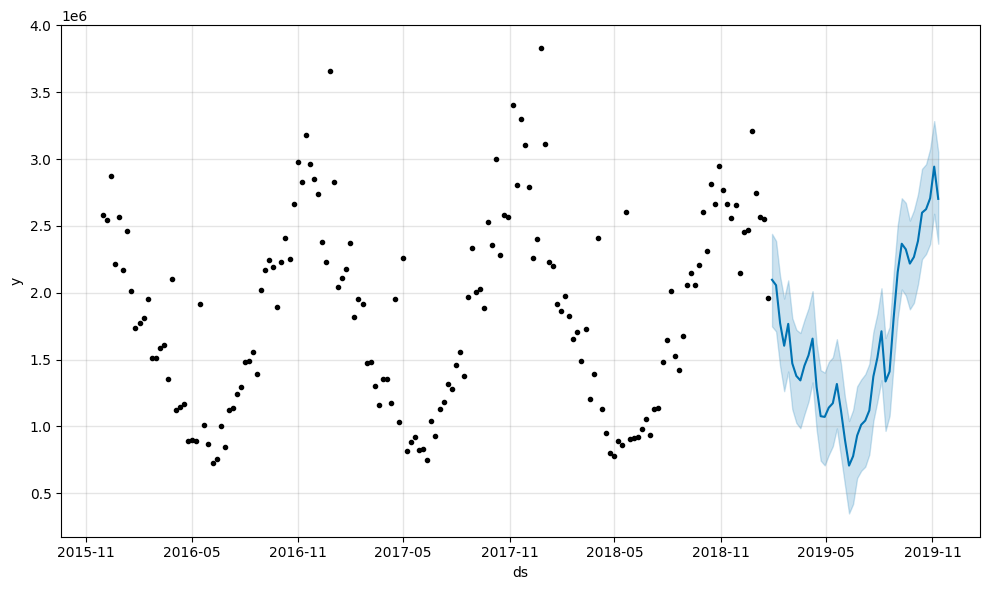

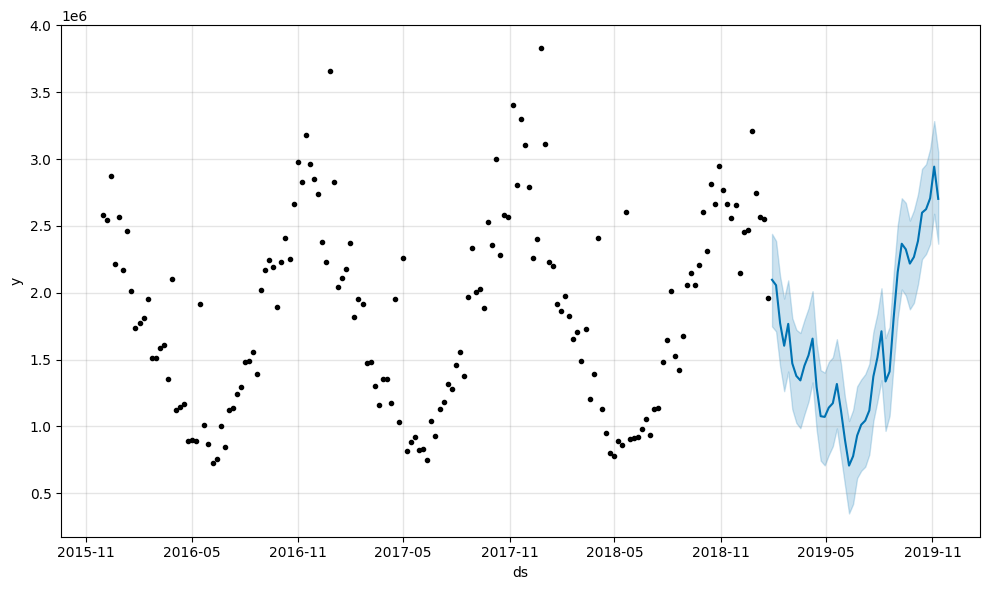

In [ ]:
model.plot(forcast_data)

In [ ]:
forcast_data2 = scalar.inverse_transform(forcast_data[['yhat', 'tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']])
forcast_data2 = pd.DataFrame(forcast_data2, columns = ['yhat', 'tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S'])

In [ ]:

test_data = test_data.reset_index( drop= True)
forcast_data2 = forcast_data.reset_index( drop= True)
output_data = pd.concat((test_data, forcast_data['yhat']), axis = 1)
output_data.rename(columns = {'revenue' : 'revenue_Actual', 'yhat' : 'revenue_predicted'}, inplace = True)
output_data

,DATE,revenue_Actual,tv_S,ooh_S,print_S,search_S,facebook_S,revenue_predicted
0,2019-01-28,2.424487e+06,31676.400000,0.000000,0.000000,15200.000000,0.000000,2.096716e+06
1,2019-02-04,1.953060e+06,0.000000,0.000000,4272.044444,13920.000000,0.000000,2.055677e+06
2,2019-02-11,2.086935e+06,12722.840000,0.000000,1191.911111,0.000000,2110.311966,1.771366e+06
3,2019-02-18,1.675817e+06,0.000000,0.000000,501.688889,0.000000,0.000000,1.602983e+06
4,2019-02-25,1.976413e+06,18120.960000,30883.200000,645.822222,12186.666667,0.000000,1.766710e+06
5,2019-03-04,1.480760e+06,0.000000,0.000000,0.000000,9946.666667,0.000000,1.471189e+06
6,2019-03-11,1.425500e+06,5490.320000,0.000000,0.000000,9040.000000,0.000000,1.377314e+06
7,2019-03-18,1.156860e+06,0.000000,0.000000,0.000000,7160.000000,6120.742451,1.343808e+06
8,2019-03-25,1.252230e+06,3483.386667,5765.333333,0.000000,7973.333333,0.000000,1.453933e+06
9,2019-04-01,1.209373e+06,0.000000,0.000000,0.000000,7880.000000,3308.655449,1.531097e+06


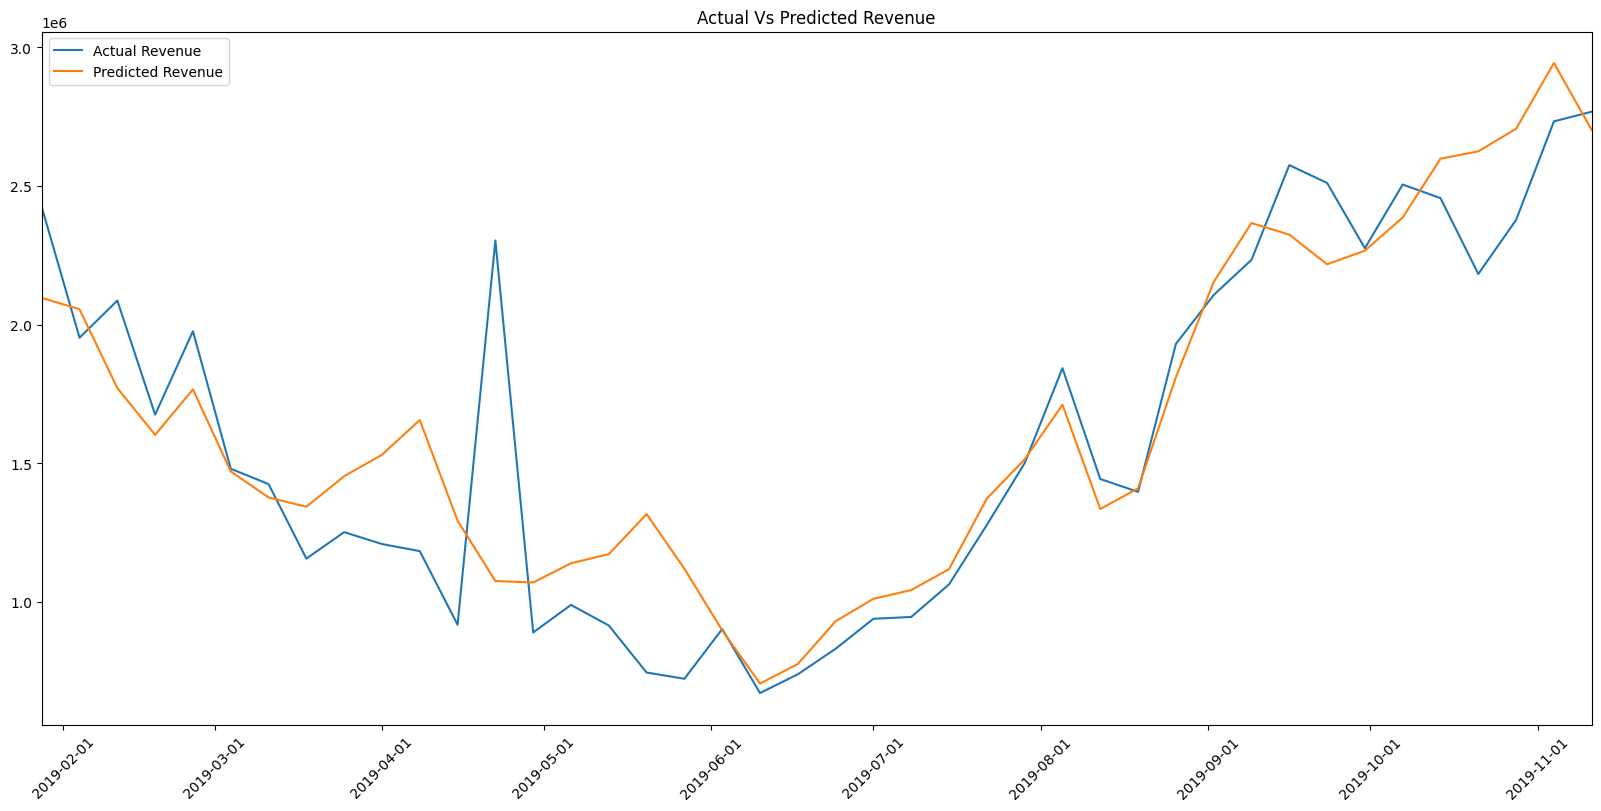

In [ ]:
# @title Actual Vs Predicted data plot
plt.rcParams["figure.figsize"] = (20,9)
plt.margins(x=0)
plt.plot(output_data['DATE'], output_data['revenue_Actual'])
plt.plot(output_data['DATE'], output_data['revenue_predicted'])
plt.legend(['Actual Revenue', 'Predicted Revenue'])
plt.xticks(rotation=45)
plt.title('Actual Vs Predicted Revenue')
dtFmt = mdates.DateFormatter('%Y-%m-%d')
plt.gca().xaxis.set_major_formatter(dtFmt)
plt.show()

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(x = output_data["DATE"], y=output_data["revenue_Actual"], name= 'Actual Revenue')
predict_chart = go.Scatter(x = output_data["DATE"], y=output_data["revenue_predicted"], name= 'Predicted Revenue')
predict_chart_upper = go.Scatter(x = output_data["DATE"], y=forcast_data["yhat_upper"], name= 'Predicted Upper')
predict_chart_lower = go.Scatter(x = output_data["DATE"], y=forcast_data["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper, predict_chart_lower], filename='Actual_vs_predicted.html')

'Actual_vs_predicted.html'

In [ ]:
cv_value = cross_validation(model, horizon='287 days')
cv_value.head()

INFO:prophet:Making 1 forecasts with cutoffs between 2018-04-09 00:00:00 and 2018-04-09 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_ma9yqg/0hatirmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl_ma9yqg/18_jwfc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85090', 'data', 'file=/tmp/tmpl_ma9yqg/0hatirmg.json', 'init=/tmp/tmpl_ma9yqg/18_jwfc1.json', 'output', 'file=/tmp/tmpl_ma9yqg/prophet_modelh8mmwkcn/prophet_model-20241009103052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:30:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-04-16,1.445834e+06,1.140422e+06,1.747590e+06,950015.000000,2018-04-09
1,2018-04-23,1.218242e+06,9.272118e+05,1.517094e+06,801298.333333,2018-04-09
2,2018-04-30,1.608037e+06,1.324453e+06,1.916145e+06,779838.333333,2018-04-09
3,2018-05-07,1.258342e+06,9.544210e+05,1.572178e+06,889546.666667,2018-04-09
4,2018-05-14,1.617774e+06,1.309225e+06,1.944121e+06,862850.000000,2018-04-09


In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_value)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,3.104003e+11,557135.797885,527439.120530,0.629711,0.521121,0.465970,0.00
1,35 days,3.914188e+11,625634.743098,592215.430712,0.717964,0.697627,0.514660,0.00
2,42 days,9.484593e+11,973888.762692,875439.518183,0.736811,0.735322,0.623544,0.00
3,49 days,7.833723e+11,885083.204099,708362.150637,0.515476,0.505157,0.490709,0.25
4,56 days,7.503261e+11,866213.679430,631625.929582,0.428811,0.386198,0.422437,0.50


In [ ]:
test_data3 = test_data[['DATE']]
col_list = ['tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']
for i in col_list:
  test_data3[i] = 0
test_data3.rename(columns = {'DATE' : 'ds'}, inplace =True)
test_data3

,ds,tv_S,ooh_S,print_S,search_S,facebook_S
0,2019-01-28,0,0,0,0,0
1,2019-02-04,0,0,0,0,0
2,2019-02-11,0,0,0,0,0
3,2019-02-18,0,0,0,0,0
4,2019-02-25,0,0,0,0,0
5,2019-03-04,0,0,0,0,0
6,2019-03-11,0,0,0,0,0
7,2019-03-18,0,0,0,0,0
8,2019-03-25,0,0,0,0,0
9,2019-04-01,0,0,0,0,0


In [ ]:
# @title Predicting data without spendings
forcast_data3 = model.predict(test_data3)
forcast_data3.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,facebook_S,facebook_S_lower,facebook_S_upper,ooh_S,ooh_S_lower,ooh_S_upper,print_S,print_S_lower,print_S_upper,search_S,search_S_lower,search_S_upper,tv_S,tv_S_lower,tv_S_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-28,1.783419e+06,1.269825e+06,1.991049e+06,1.783419e+06,1.783419e+06,-164198.511558,-164198.511558,-164198.511558,-215284.154998,-215284.154998,-215284.154998,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-31856.479745,-31856.479745,-31856.479745,-125041.759675,-125041.759675,-125041.759675,-62976.296011,-62976.296011,-62976.296011,51085.643440,51085.643440,51085.643440,0.0,0.0,0.0,1.619220e+06
1,2019-02-04,1.782687e+06,1.359405e+06,2.025439e+06,1.782687e+06,1.782688e+06,-88832.437015,-88832.437015,-88832.437015,-215284.154998,-215284.154998,-215284.154998,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-31856.479745,-31856.479745,-31856.479745,-125041.759675,-125041.759675,-125041.759675,-62976.296011,-62976.296011,-62976.296011,126451.717983,126451.717983,126451.717983,0.0,0.0,0.0,1.693855e+06
2,2019-02-11,1.781956e+06,1.362391e+06,2.044432e+06,1.781956e+06,1.781957e+06,-73745.053726,-73745.053726,-73745.053726,-215284.154998,-215284.154998,-215284.154998,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-31856.479745,-31856.479745,-31856.479745,-125041.759675,-125041.759675,-125041.759675,-62976.296011,-62976.296011,-62976.296011,141539.101272,141539.101272,141539.101272,0.0,0.0,0.0,1.708211e+06
3,2019-02-18,1.781225e+06,1.251679e+06,1.940261e+06,1.781224e+06,1.781227e+06,-182260.604776,-182260.604776,-182260.604776,-215284.154998,-215284.154998,-215284.154998,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-31856.479745,-31856.479745,-31856.479745,-125041.759675,-125041.759675,-125041.759675,-62976.296011,-62976.296011,-62976.296011,33023.550222,33023.550222,33023.550222,0.0,0.0,0.0,1.598965e+06
4,2019-02-25,1.780494e+06,1.064368e+06,1.751229e+06,1.780492e+06,1.780496e+06,-368313.120762,-368313.120762,-368313.120762,-215284.154998,-215284.154998,-215284.154998,-5573.557525,-5573.557525,-5573.557525,10163.937959,10163.937959,10163.937959,-31856.479745,-31856.479745,-31856.479745,-125041.759675,-125041.759675,-125041.759675,-62976.296011,-62976.296011,-62976.296011,-153028.965765,-153028.965765,-153028.965765,0.0,0.0,0.0,1.412181e+06


In [ ]:
output_data = pd.concat((output_data, forcast_data3['yhat']), axis = 1)
output_data.rename(columns = {'yhat' : 'revenue_predicted_without_spendings'}, inplace = True)
output_data

,DATE,revenue_Actual,tv_S,ooh_S,print_S,search_S,facebook_S,revenue_predicted,revenue_predicted_without_spendings
0,2019-01-28,2.424487e+06,31676.400000,0.000000,0.000000,15200.000000,0.000000,2.096716e+06,1.619220e+06
1,2019-02-04,1.953060e+06,0.000000,0.000000,4272.044444,13920.000000,0.000000,2.055677e+06,1.693855e+06
2,2019-02-11,2.086935e+06,12722.840000,0.000000,1191.911111,0.000000,2110.311966,1.771366e+06,1.708211e+06
3,2019-02-18,1.675817e+06,0.000000,0.000000,501.688889,0.000000,0.000000,1.602983e+06,1.598965e+06
4,2019-02-25,1.976413e+06,18120.960000,30883.200000,645.822222,12186.666667,0.000000,1.766710e+06,1.412181e+06
5,2019-03-04,1.480760e+06,0.000000,0.000000,0.000000,9946.666667,0.000000,1.471189e+06,1.237095e+06
6,2019-03-11,1.425500e+06,5490.320000,0.000000,0.000000,9040.000000,0.000000,1.377314e+06,1.143800e+06
7,2019-03-18,1.156860e+06,0.000000,0.000000,0.000000,7160.000000,6120.742451,1.343808e+06,1.159336e+06
8,2019-03-25,1.252230e+06,3483.386667,5765.333333,0.000000,7973.333333,0.000000,1.453933e+06,1.254225e+06
9,2019-04-01,1.209373e+06,0.000000,0.000000,0.000000,7880.000000,3308.655449,1.531097e+06,1.337014e+06


In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
#Plot predicted and actual line graph with X=dates, Y=Outbound
actual_chart = go.Scatter(x = output_data["DATE"], y=output_data["revenue_Actual"], name= 'Actual Revenue')
predict_chart = go.Scatter(x = output_data["DATE"], y=output_data["revenue_predicted"], name= 'Predicted Revenue')
predict_chart_upper = go.Scatter(x = output_data["DATE"], y=output_data["revenue_predicted_without_spendings"], name= 'revenue_predicted_without_spendings')
# predict_chart_lower = go.Scatter(x = output_data["DATE"], y=forcast_data["yhat_lower"], name= 'Predicted Lower')
py.plot([actual_chart, predict_chart, predict_chart_upper], filename='Actual_vs_predicted_vs_without.html')

'Actual_vs_predicted_vs_without.html'

In [ ]:
col_list = ['tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']
# test_data4 = test_data3
for i in col_list:
  test_data4 = test_data3.copy()
  test_data4[i] = test_data[i]
  print(test_data4,'\n', '___'*22)
  forcast_data4 = model.predict(test_data4)
  output_data = pd.concat((output_data, forcast_data4['yhat']), axis = 1)
  col_name = 'revenue_predicted_with_' + i + '_spendings'
  output_data.rename(columns = {'yhat' : col_name}, inplace = True)
  del test_data4

           ds          tv_S  ooh_S  print_S  search_S  facebook_S
0  2019-01-28  31676.400000      0        0         0           0
1  2019-02-04      0.000000      0        0         0           0
2  2019-02-11  12722.840000      0        0         0           0
3  2019-02-18      0.000000      0        0         0           0
4  2019-02-25  18120.960000      0        0         0           0
5  2019-03-04      0.000000      0        0         0           0
6  2019-03-11   5490.320000      0        0         0           0
7  2019-03-18      0.000000      0        0         0           0
8  2019-03-25   3483.386667      0        0         0           0
9  2019-04-01      0.000000      0        0         0           0
10 2019-04-08  47889.813333      0        0         0           0
11 2019-04-15      0.000000      0        0         0           0
12 2019-04-22   4878.400000      0        0         0           0
13 2019-04-29      0.000000      0        0         0           0
14 2019-05

In [ ]:
output_data.to_csv('output_data.csv')
output_data

,DATE,revenue_Actual,tv_S,ooh_S,print_S,search_S,facebook_S,revenue_predicted,revenue_predicted_without_spendings,revenue_predicted_with_tv_S_spendings,revenue_predicted_with_ooh_S_spendings,revenue_predicted_with_print_S_spendings,revenue_predicted_with_search_S_spendings,revenue_predicted_with_facebook_S_spendings
0,2019-01-28,2.424487e+06,31676.400000,0.000000,0.000000,15200.000000,0.000000,2.096716e+06,1.619220e+06,1.738987e+06,1.619220e+06,1.619220e+06,1.976950e+06,1.619220e+06
1,2019-02-04,1.953060e+06,0.000000,0.000000,4272.044444,13920.000000,0.000000,2.055677e+06,1.693855e+06,1.693855e+06,1.693855e+06,1.728073e+06,2.021460e+06,1.693855e+06
2,2019-02-11,2.086935e+06,12722.840000,0.000000,1191.911111,0.000000,2110.311966,1.771366e+06,1.708211e+06,1.756316e+06,1.708211e+06,1.717758e+06,1.708211e+06,1.713715e+06
3,2019-02-18,1.675817e+06,0.000000,0.000000,501.688889,0.000000,0.000000,1.602983e+06,1.598965e+06,1.598965e+06,1.598965e+06,1.602983e+06,1.598965e+06,1.598965e+06
4,2019-02-25,1.976413e+06,18120.960000,30883.200000,645.822222,12186.666667,0.000000,1.766710e+06,1.412181e+06,1.480695e+06,1.406212e+06,1.417354e+06,1.698992e+06,1.412181e+06
5,2019-03-04,1.480760e+06,0.000000,0.000000,0.000000,9946.666667,0.000000,1.471189e+06,1.237095e+06,1.237095e+06,1.237095e+06,1.237095e+06,1.471189e+06,1.237095e+06
6,2019-03-11,1.425500e+06,5490.320000,0.000000,0.000000,9040.000000,0.000000,1.377314e+06,1.143800e+06,1.164559e+06,1.143800e+06,1.143800e+06,1.356555e+06,1.143800e+06
7,2019-03-18,1.156860e+06,0.000000,0.000000,0.000000,7160.000000,6120.742451,1.343808e+06,1.159336e+06,1.159336e+06,1.159336e+06,1.159336e+06,1.327846e+06,1.175298e+06
8,2019-03-25,1.252230e+06,3483.386667,5765.333333,0.000000,7973.333333,0.000000,1.453933e+06,1.254225e+06,1.267396e+06,1.253111e+06,1.254225e+06,1.441877e+06,1.254225e+06
9,2019-04-01,1.209373e+06,0.000000,0.000000,0.000000,7880.000000,3308.655449,1.531097e+06,1.337014e+06,1.337014e+06,1.337014e+06,1.337014e+06,1.522468e+06,1.345642e+06


In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
out_col = []
for j in [c for c in output_data.columns if c not in ['DATE', 'tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']]:
  actual_chart = go.Scatter(x = output_data["DATE"], y=output_data[j], name= j)
  out_col.append(actual_chart)
py.plot(out_col, filename= 'all_data.html')

'all_data.html'

In [ ]:
output_data.shape

(42, 35)

In [ ]:
output_data = output_data.reset_index(drop = True)
for k in [c for c in output_data.columns if c not in ['DATE', 'tv_S', 'ooh_S', 'print_S', 'search_S', 'facebook_S']]:
  # print(output_data[k].shape)
  print(k, root_mean_squared_error(output_data['revenue_Actual'], output_data[k]))


level_0 1735226.5872868607
index 1735226.5872868607
revenue_Actual 0.0
revenue_predicted 291183.93993119994
revenue_predicted_without_spendings 391452.8415440678
revenue_predicted_with_tv_S_spendings 374085.7844657933
revenue_predicted_with_ooh_S_spendings 392487.29752274643
revenue_predicted_with_print_S_spendings 377046.6542392062
revenue_predicted_with_search_S_spendings 289599.92147952964
revenue_predicted_with_facebook_S_spendings 388247.12910523126
